In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim

In [3]:
import tqdm
import ngmix

def _ngmix_g1g2(im, scale=0.263, fwhm=0.9):
    T = ngmix.moments.fwhm_to_T(fwhm)

    # the weight is always centered at 0, 0 or the
    # center of the coordinate system as defined
    # by the jacobian
    weight = ngmix.GMixModel(
        [0.0, 0.0, 0.0, 0.0, T, 1.0],
        'gauss',
    )

    # make the max of the weight 1.0 to get better
    # fluxes
    weight.set_norms()
    norm = weight.get_data()['norm'][0]
    weight.set_flux(1.0/norm)

    obs = ngmix.Observation(
        image=im,
        jacobian=ngmix.DiagonalJacobian(scale=scale, row=8, col=8))
    res = weight.get_weighted_moments(obs=obs, maxrad=1.e9)
    return res['e'][0], res['e'][1]

def _get_fwhm_g1g2(psf_im):
    #g1, g2 = _ngmix_g1g2(psf_im.array, fwhm=0.9)
    mom = galsim.hsm.FindAdaptiveMom(psf_im)
    return (
        mom.moments_sigma * psf_im.scale * 2.355, 
        mom.observed_shape.g1, 
        mom.observed_shape.g2,
        psf_im.calculateFWHM())


def _measure_atm(ims, scale):
    n = ims.shape[0]
    fwhms = np.zeros((n, n))
    g1 = np.zeros_like(fwhms)
    g2 = np.zeros_like(fwhms)
    for i in tqdm.trange(n):
        for j in range(n):
            psf_im = galsim.ImageD(ims[j, i], scale=scale)
            res = _get_fwhm_g1g2(psf_im)
            fwhms[j, i] = res[0]
            g1[j, i] = res[1]
            g2[j, i] = res[2]
    return fwhms, g1, g2

In [30]:
from mdetsims.real_psf import RealPSF

d = RealPSF('test_seed10_n1e8_lhs256.fits')

  8%|▊         | 4/50 [00:01<00:12,  3.54it/s]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([8.92102051, 7.5737915 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
100%|██████████| 50/50 [00:06<00:00, 19.88it/s]


In [31]:
def _make_pca_image(_x, _y):
    return d.getPSF(galsim.PositionD(x=_x, y=_y)).image.array

ims = np.zeros((225, 225, 17, 17))
for y in tqdm.trange(0, 225):
    for x in range(0, 225):
        ims[y, x] = _make_pca_image(x, y)

100%|██████████| 225/225 [07:42<00:00,  1.83s/it]


In [32]:
fwhms, g1, g2 = _measure_atm(ims, 0.263)

100%|██████████| 225/225 [00:31<00:00,  7.45it/s]


Text(0.5, 1.0, 'g2')

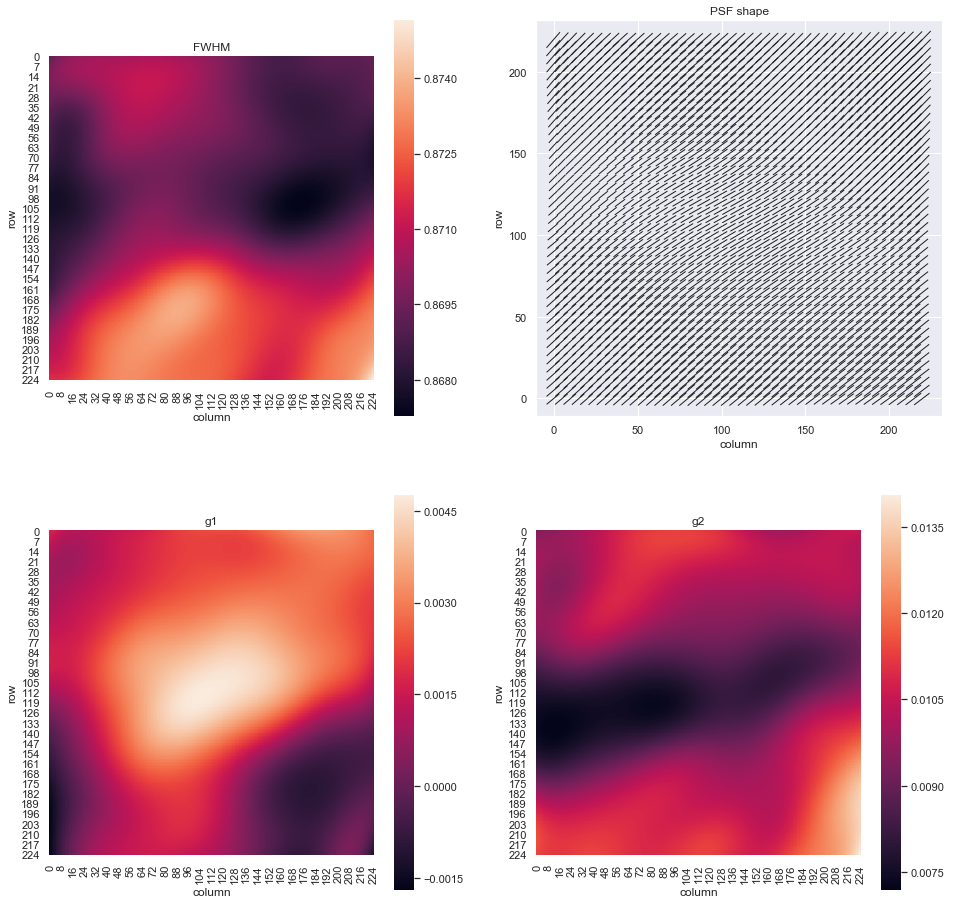

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2, g1)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

Text(0.5, 1.0, 'g2')

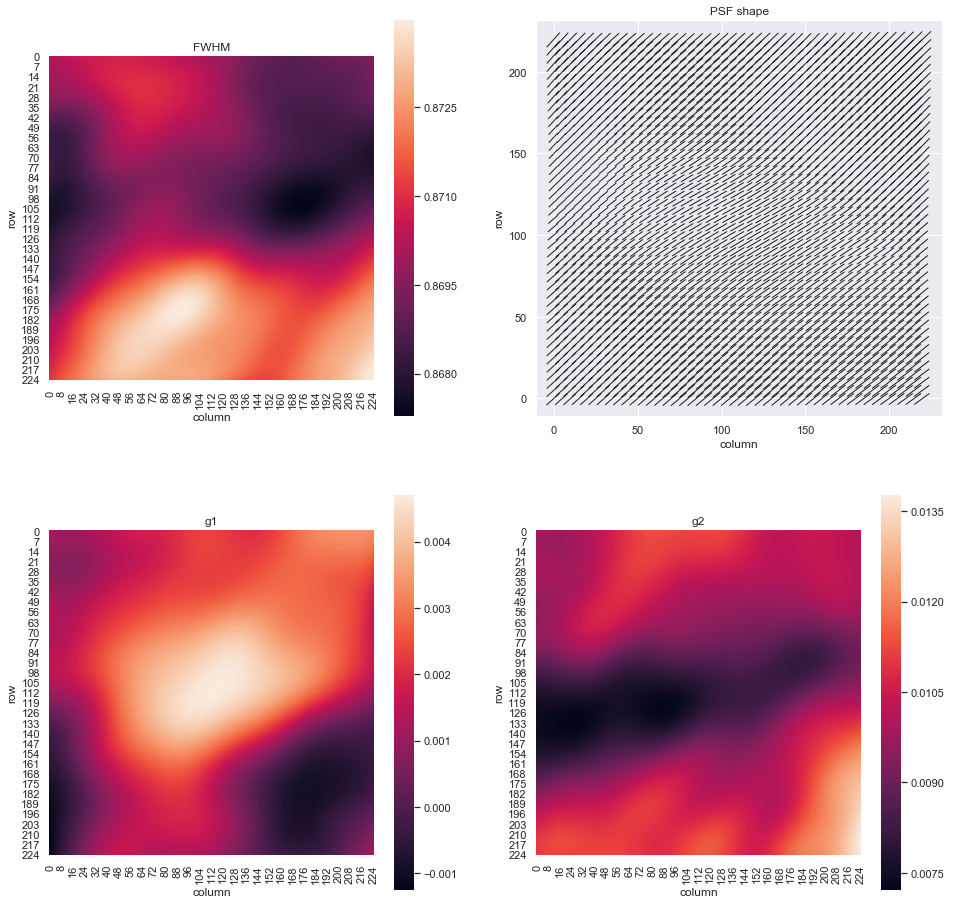

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2, g1)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

Text(0.5, 1.0, 'g2')

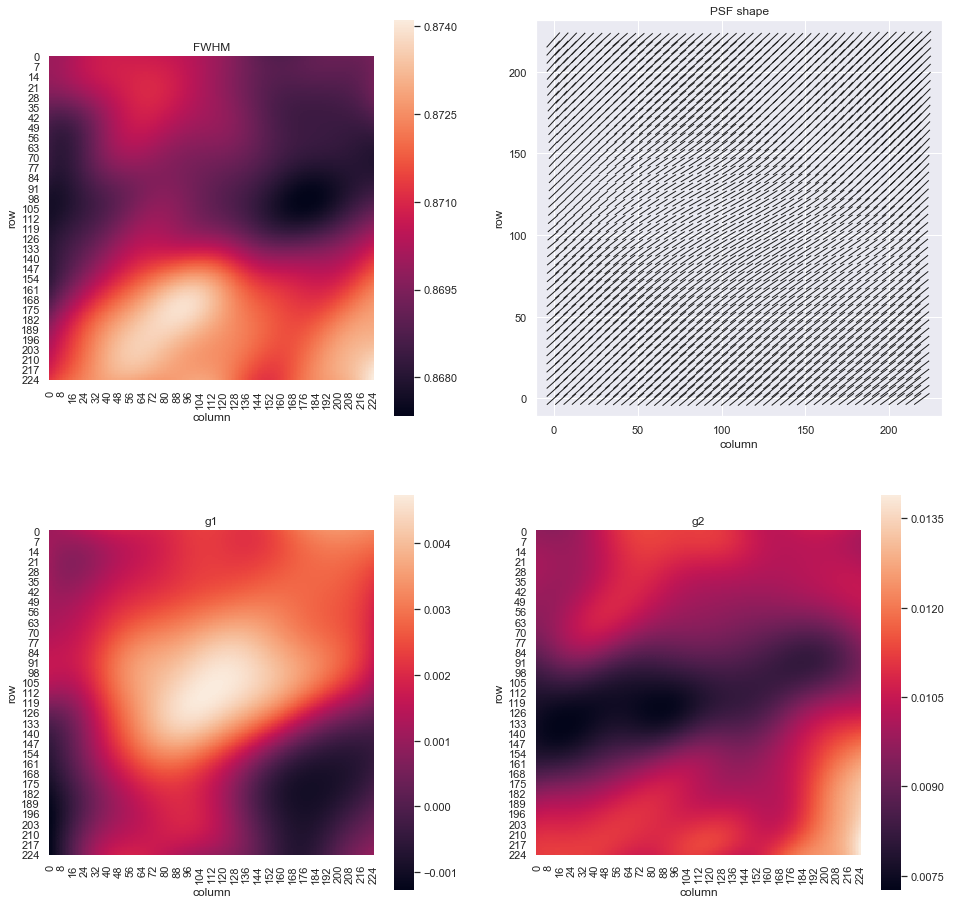

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2, g1)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

Text(0.5, 1.0, 'g2')

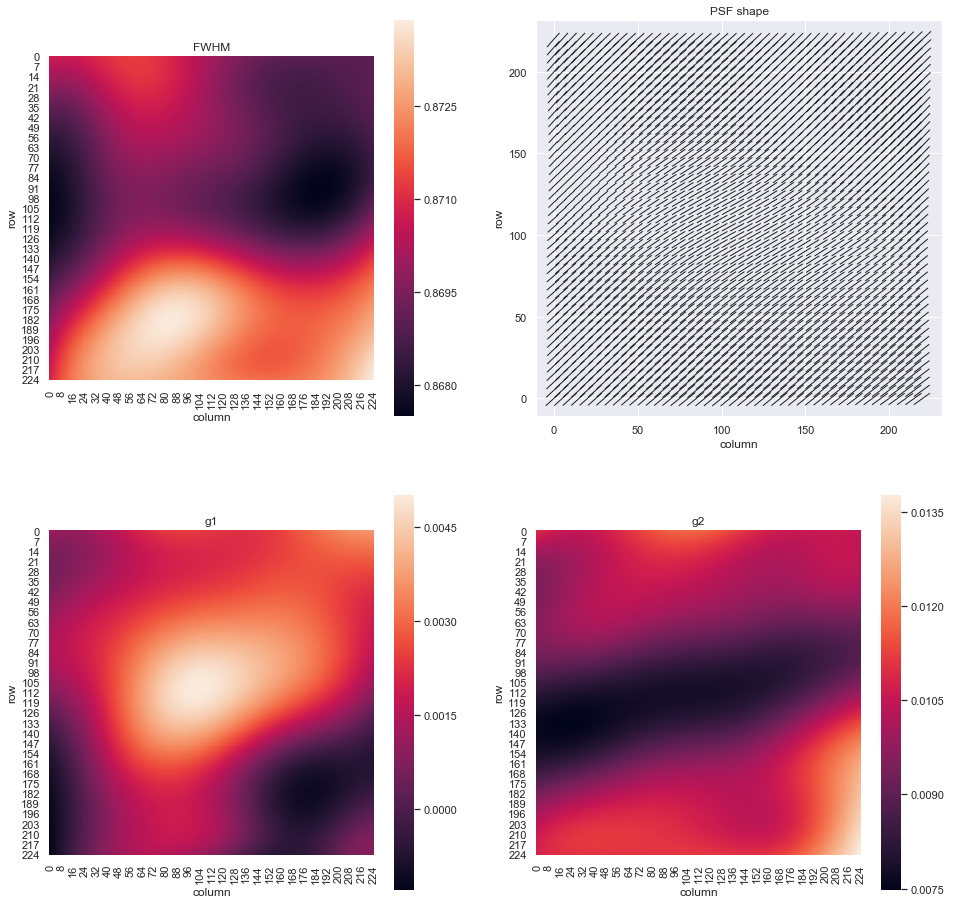

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

kwargs = {}
sns.heatmap(fwhms, square=True, ax=axs[0, 0], **kwargs)
axs[0, 0].set_xlabel('column')
axs[0, 0].set_ylabel('row')
axs[0, 0].set_title('FWHM')

g = np.sqrt(g1**2 + g2**2)
g /= np.mean(g)
loc = np.arange(g.shape[0]) + 0.5
beta = np.arctan2(g2, g1)/2
axs[0, 1].quiver(
    loc[::5],
    loc[::5],
    (g * np.cos(beta))[::5, ::5],
    (g * np.sin(beta))[::5, ::5],
    scale_units='xy',
    scale=0.075,
    headwidth=0,
    pivot='mid')
axs[0, 1].set_xlabel('column')
axs[0, 1].set_ylabel('row')
axs[0, 1].set_title('PSF shape')

sns.heatmap(g1, square=True, ax=axs[1, 0], **kwargs)
axs[1, 0].set_xlabel('column')
axs[1, 0].set_ylabel('row')
axs[1, 0].set_title('g1')

sns.heatmap(g2, square=True, ax=axs[1, 1], **kwargs)
axs[1, 1].set_xlabel('column')
axs[1, 1].set_ylabel('row')
axs[1, 1].set_title('g2')

In [24]:
d8 = RealPSF('test_seed10_n1e8_lhs512.fits')
d9 = RealPSF('test_seed10_n1e9_lhs64.fits')

  6%|▌         | 3/50 [00:02<00:38,  1.23it/s]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([31.3046875 , -1.92281407]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
 30%|███       | 15/50 [00:18<00:50,  1.43s/it]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.95727769e+01, -7.55049477e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
 64%|██████▍   | 32/50 [00:48<00:24,  1.34s/it]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.99922517e-01, 1.5634207

[ 30.77453359 153.68189166] [ 30.77453359 153.68189166]


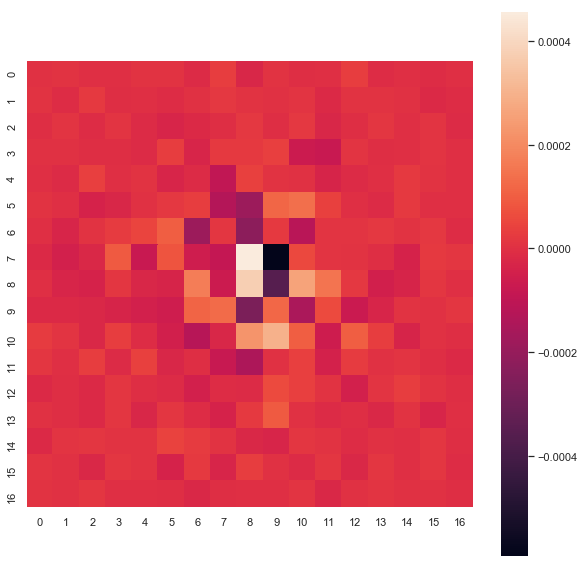

In [29]:
ind = 10

print(d8.psf_locs[ind], d9.psf_locs[ind])

plt.figure(figsize=(10, 10))
sns.heatmap(
    (d8.psf_images[ind, :, :] - d9.psf_images[ind, :, :])/np.max(d9.psf_images[ind, :, :]), 
    square=True)

In [26]:
def _get_s2n(im):
    nse = np.std(im[:, 0].tolist() + im[:, -1].tolist())
    s2n = np.sqrt(np.sum(im**2)) / nse
    return s2n

print('1e8:', _get_s2n(d8.psf_images[ind, :, :]))
print('1e9:', _get_s2n(d9.psf_images[ind, :, :]))

1e8: 4746.430294350474
1e9: 4733.433022289493


In [27]:
from mdetsims.real_psf import RealPSFGenerator
import galsim

In [28]:
r = RealPSFGenerator(seed=10, scale=0.263, im_width=225, n_photons=1e6) 

In [ ]:
im1010 = np.zeros((17, 17))
for _ in tqdm.trange(10):
    im1010 += r.getPSF(galsim.PositionD(x=10, y=10)).drawImage(
        nx=r.psf_width,
        ny=r.psf_width,
        scale=r.scale,
        method='phot',
        n_photons=r.n_photons,).array

In [ ]:
im1011 = np.zeros((17, 17))
for _ in tqdm.trange(100):
    im1011 += r.getPSF(galsim.PositionD(x=10, y=11)).drawImage(
        nx=r.psf_width,
        ny=r.psf_width,
        scale=r.scale,
        method='phot',
        n_photons=r.n_photons,).array

In [ ]:
im1015 = np.zeros((17, 17))
for _ in tqdm.trange(100):
    im1015 += r.getPSF(galsim.PositionD(x=10, y=15)).drawImage(
        nx=r.psf_width,
        ny=r.psf_width,
        scale=r.scale,
        method='phot',
        n_photons=1e6).array

In [ ]:
print(_get_fwhm_g1g2(galsim.ImageD(im1010, scale=0.263)))
print(_get_fwhm_g1g2(galsim.ImageD(im1011, scale=0.263)))
print(_get_fwhm_g1g2(galsim.ImageD(im1015, scale=0.263)))

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap((im1010 - im1015)/np.max(im1011), square=True)